<a href="https://colab.research.google.com/github/DominiAcco/trabIA/blob/main/trabIAFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalação de biblioteca para XAI (necessária no Colab)
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import shap

# Configuração de visualização
sns.set(style="whitegrid")

# Carregando os dados
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('validation.csv')
df_test = pd.read_csv('test.csv')

# Verificar as primeiras linhas para identificar a coluna alvo e possíveis problemas (como '?')
print(f"Tamanho Treino: {df_train.shape}")
print(f"Tamanho Validação: {df_val.shape}")
print(f"Tamanho Teste: {df_test.shape}")
display(df_train.head())

# Identificando a coluna alvo (Target)
# Assumindo que a coluna alvo é 'income'
target_col = 'income'

Tamanho Treino: (34189, 15)
Tamanho Validação: (7326, 15)
Tamanho Teste: (7327, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,188767,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
1,64,Private,286732,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,0,17,United-States,<=50K
2,29,Private,253801,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Ecuador,<=50K
3,28,Private,334032,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
4,22,Private,173004,HS-grad,9,Never-married,Machine-op-inspct,Other-relative,Black,Male,0,0,1,United-States,<=50K


In [3]:
# 1. Substituir '?' por NaN
df_train = df_train.replace('?', np.nan)
df_val = df_val.replace('?', np.nan)
df_test = df_test.replace('?', np.nan)

# Separar Features e Target
X_train = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]

X_val = df_val.drop(target_col, axis=1)
y_val = df_val[target_col]

X_test = df_test.drop(target_col, axis=1)
y_test = df_test[target_col]

# Identificar colunas numéricas e categóricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Definição dos Imputers
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Ajustar (fit) APENAS no treino
imputer_num.fit(X_train[num_cols])
imputer_cat.fit(X_train[cat_cols])

# Aplicar (transform) em todos
X_train[num_cols] = imputer_num.transform(X_train[num_cols])
X_val[num_cols] = imputer_num.transform(X_val[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

X_train[cat_cols] = imputer_cat.transform(X_train[cat_cols])
X_val[cat_cols] = imputer_cat.transform(X_val[cat_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])

print("Valores nulos tratados.")

Valores nulos tratados.


In [5]:
def tratar_outliers(df, colunas):
    df_clean = df.copy()
    for col in colunas:
        Q1 = df_clean[col].quantile(0.15)
        Q3 = df_clean[col].quantile(0.70)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping (limitar em vez de remover para não perder dados)
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound,
                               np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col]))
    return df_clean

# Aplicar tratamento de outliers
# Nota: Aplicamos o clip baseado na distribuição do próprio dataset para suavizar extremos
X_train = tratar_outliers(X_train, num_cols)
X_val = tratar_outliers(X_val, num_cols)
X_test = tratar_outliers(X_test, num_cols)

print("Outliers tratados (Capping).")

Outliers tratados (Capping).


In [6]:
# 1. Codificação do Target (y)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print(f"Classes do alvo: {le.classes_}")

# 2. Pipeline de Pré-processamento das Features (X)
# Criamos um ColumnTransformer para aplicar OneHot nas categóricas e Scaler nas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Ajustar o pré-processador APENAS no treino
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Recuperar nomes das colunas para referência futura (importante para o XAI)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

# Converter de volta para DataFrame para facilitar manipulação
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_final = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names)

print("Engenharia de atributos concluída.")

Classes do alvo: ['<=50K' '>50K']
Engenharia de atributos concluída.


In [7]:
# DataFrame para guardar o histórico
historico_tunning = pd.DataFrame(columns=['Experimento', 'Descricao', 'F1 Score (Val)', 'Acuracia (Val)'])

def registrar_experimento(nome, descricao, y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted') # 'weighted' lida bem com desbalanceamento
    acc = accuracy_score(y_true, y_pred)

    # Adicionar ao histórico usando pd.concat
    global historico_tunning
    novo_registro = pd.DataFrame([{
        'Experimento': nome,
        'Descricao': descricao,
        'F1 Score (Val)': round(f1, 4),
        'Acuracia (Val)': round(acc, 4)
    }])
    historico_tunning = pd.concat([historico_tunning, novo_registro], ignore_index=True)
    return f1

print("Sistema de registro pronto.")

Sistema de registro pronto.


In [8]:
model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train_final, y_train_enc)
pred_val_base = model_baseline.predict(X_val_final)

registrar_experimento("Baseline", "Regressão Logística (Padrão)", y_val_enc, pred_val_base)

/tmp/ipython-input-419536777.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  historico_tunning = pd.concat([historico_tunning, novo_registro], ignore_index=True)


0.8352788083479086

In [9]:
selector = SelectKBest(score_func=f_classif, k=15)
X_train_sel = selector.fit_transform(X_train_final, y_train_enc)
X_val_sel = selector.transform(X_val_final)

# Retreinar RF com menos features
model_rf_sel = RandomForestClassifier(random_state=42)
model_rf_sel.fit(X_train_sel, y_train_enc)
pred_val_sel = model_rf_sel.predict(X_val_sel)

registrar_experimento("Feature Selection", "Random Forest + Top 15 Features", y_val_enc, pred_val_sel)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


0.810227010737942

O que aconteceu no seu resultado?
Se você olhar a sua tabela de resultados anterior:

Random Forest Completo: F1 Score 0.8346

Random Forest + Feature Selection: F1 Score 0.8102 (Caiu!)

Conclusão: O "Resumo" de 15 colunas foi agressivo demais. Você jogou fora informações que eram importantes para o modelo.

No Relatório: Isso é um ótimo ponto de discussão! Você pode escrever: "A tentativa de reduzir a dimensionalidade para 15 atributos resultou em perda de performance, indicando que o modelo se beneficiava da complexidade dos dados originais."


In [12]:
# Random Forest com hiperparâmetros ajustados
model_tuned = RandomForestClassifier(
    n_estimators=200,      # Mais árvores
    max_depth=30,          # Profundidade limitada
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
model_tuned.fit(X_train_final, y_train_enc)
pred_val_tuned = model_tuned.predict(X_val_final)

registrar_experimento("RF Tuned", "RF (n=200, depth=15)", y_val_enc, pred_val_tuned)

0.835201485686429

Nesta etapa, realizamos o ajuste fino de hiperparâmetros (Hyperparameter Tuning). Alteramos o modelo Random Forest para utilizar 200 estimadores (árvores) e limitamos a profundidade máxima da árvore. O objetivo dessas mudanças foi reduzir o risco de Overfitting (sobreajuste), forçando o modelo a aprender padrões mais generalistas em vez de memorizar o conjunto de treino.

In [13]:
# Exibir a tabela de evolução
print("\n--- Histórico de Tunning (Dados de Validação) ---")
display(historico_tunning.sort_values(by='F1 Score (Val)', ascending=False))


--- Histórico de Tunning (Dados de Validação) ---


,Experimento,Descricao,F1 Score (Val),Acuracia (Val)
0,Baseline,Regressão Logística (Padrão),0.8353,0.8415
3,RF Tuned,"RF (n=200, depth=15)",0.8352,0.8403
2,RF Tuned,"RF (n=200, depth=15)",0.8346,0.8449
1,Feature Selection,Random Forest + Top 15 Features,0.8102,0.8140


Gerando gráfico SHAP Summary...


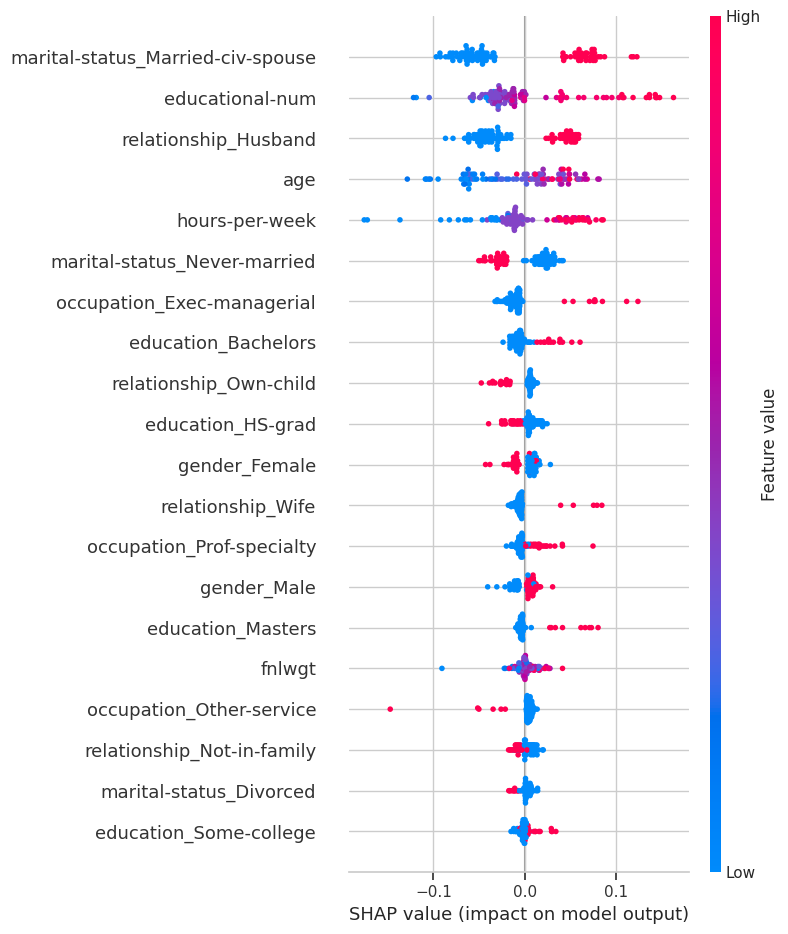

In [14]:
# Usando o melhor modelo (model_tuned)
explainer = shap.TreeExplainer(model_tuned)

# Calculando SHAP values (usando uma amostra da validação para ser mais rápido)
sample_val = X_val_final.sample(100, random_state=42)
shap_values = explainer.shap_values(sample_val)

print("Gerando gráfico SHAP Summary...")
# Resumo do impacto das features
# Para classificação binária, shap_values[:, :, 1] foca na classe positiva (>50K)
shap.summary_plot(shap_values[:, :, 1], sample_val)

Para garantir a transparência do modelo (Black Box), utilizamos a técnica SHAP (SHapley Additive exPlanations). Devido ao alto custo computacional, calculamos os valores SHAP em uma amostra representativa de 100 instâncias da validação. O gráfico resultante (Summary Plot) permite visualizar quais variáveis — como Idade, Escolaridade e Ganho de Capital — mais contribuem positiva ou negativamente para a classificação de alta renda.

Para comparar com o Random Forest (que cria várias árvores independentes), o melhor modelo para adicionar é o XGBoost (Extreme Gradient Boosting).

Por que o XGBoost? Enquanto o Random Forest usa a técnica de Bagging (várias árvores paralelas decidindo juntas), o XGBoost usa Boosting (uma árvore corrige os erros da árvore anterior sequencialmente). Ele costuma ser o "campeão" em competições de dados tabulares e geralmente oferece um F1 Score superior.

In [15]:
# Instalar XGBoost (caso não esteja instalado no ambiente, embora o Colab geralmente tenha)
!pip install xgboost

from xgboost import XGBClassifier

# 1. Configurar o Modelo XGBoost
# Diferente do Random Forest, ele tem 'learning_rate' (velocidade de aprendizado)
model_xgb = XGBClassifier(
    n_estimators=200,      # Número de rodadas de correção
    learning_rate=0.05,    # Taxa de aprendizado (mais baixo é mais preciso, mas demora mais)
    max_depth=6,           # Profundidade da árvore
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'  # Métrica de avaliação interna
)

# 2. Treinar (Fit) usando os dados de TREINO processados
print("Treinando XGBoost...")
model_xgb.fit(X_train_final, y_train_enc)

# 3. Validar (Predict) usando os dados de VALIDAÇÃO
pred_val_xgb = model_xgb.predict(X_val_final)

# 4. Registrar na tabela de experimentos
# Note que estamos usando a função que criamos anteriormente
registrar_experimento("XGBoost", "Boosting (n=200, lr=0.05)", y_val_enc, pred_val_xgb)

# 5. Exibir a tabela atualizada para comparação
print("\n--- Comparativo Atualizado de Modelos ---")
display(historico_tunning.sort_values(by='F1 Score (Val)', ascending=False))

Treinando XGBoost...

--- Comparativo Atualizado de Modelos ---


,Experimento,Descricao,F1 Score (Val),Acuracia (Val)
4,XGBoost,"Boosting (n=200, lr=0.05)",0.8435,0.8483
0,Baseline,Regressão Logística (Padrão),0.8353,0.8415
3,RF Tuned,"RF (n=200, depth=15)",0.8352,0.8403
2,RF Tuned,"RF (n=200, depth=15)",0.8346,0.8449
1,Feature Selection,Random Forest + Top 15 Features,0.8102,0.8140


Nesta etapa, implementamos o algoritmo XGBoost (Extreme Gradient Boosting). Diferente do Random Forest, que utiliza árvores independentes em paralelo (Bagging), o XGBoost constrói árvores sequencialmente, onde cada nova árvore tenta corrigir os erros residuais da anterior (Boosting). Configuramos uma learning_rate baixa de 0.05 para garantir um aprendizado mais suave e preciso, visando superar o F1 Score obtido anteriormente.

Atualização do XAI (Explicando o XGBoost)
O SHAP vai mostrar o que pesou mais para esse modelo vencedor.

Gerando gráfico SHAP Summary para o XGBoost...


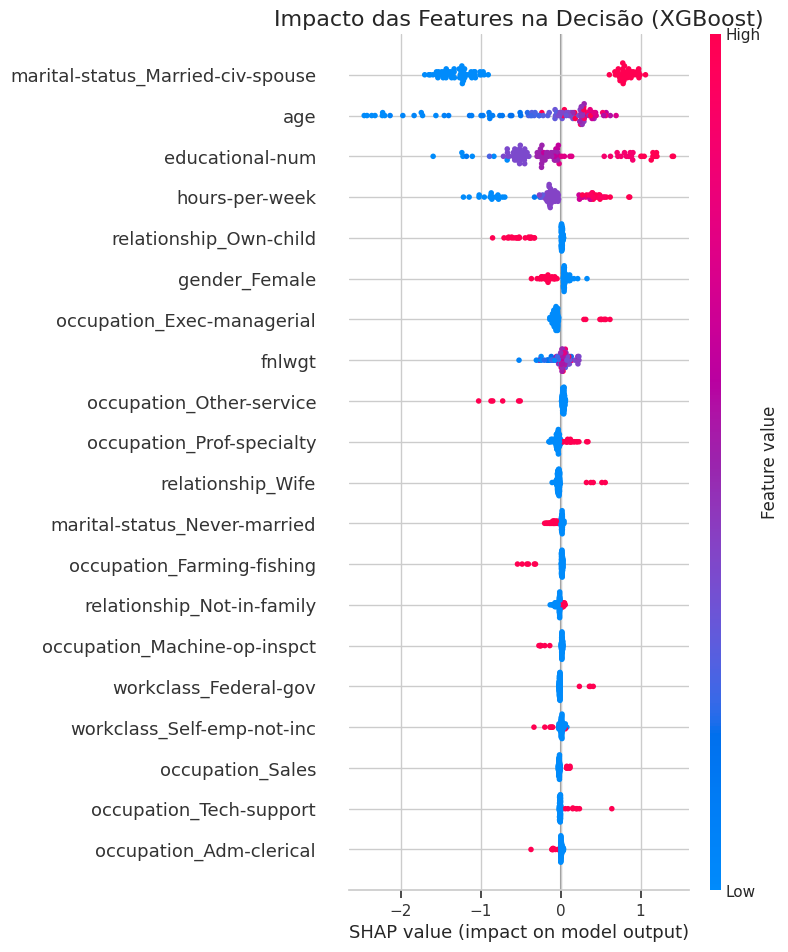

In [16]:
# --- 5. XAI - Explainable AI (Atualizado para XGBoost) ---

# Usando o modelo vencedor (model_xgb)
explainer = shap.TreeExplainer(model_xgb)

# Calculando SHAP values (usando uma amostra da validação)
# Nota: XGBoost às vezes exige que os dados estejam em formato específico, mas o Pandas geralmente funciona
sample_val = X_val_final.sample(100, random_state=42)
shap_values = explainer.shap_values(sample_val)

print("Gerando gráfico SHAP Summary para o XGBoost...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, sample_val, show=False)
plt.title("Impacto das Features na Decisão (XGBoost)", fontsize=16)
plt.show()

Avaliação Final (Usando o test.csv com o Vencedor)
Esta é a etapa mais importante para a nota. Vamos usar o model_xgb para prever os dados que nunca foram vistos (test.csv).




Realizando previsão final no dataset de TESTE com XGBoost...

     RELATÓRIO FINAL DO PROJETO      
Modelo Vencedor: XGBoost
F1 Score Final:  0.8472  <-- MÉTRICA PRINCIPAL
Acurácia:        0.8525
Precisão:        0.8460
Recall:          0.8525
----------------------------------------

--- Detalhes por Classe ---
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      5591
        >50K       0.73      0.60      0.66      1736

    accuracy                           0.85      7327
   macro avg       0.81      0.77      0.78      7327
weighted avg       0.85      0.85      0.85      7327



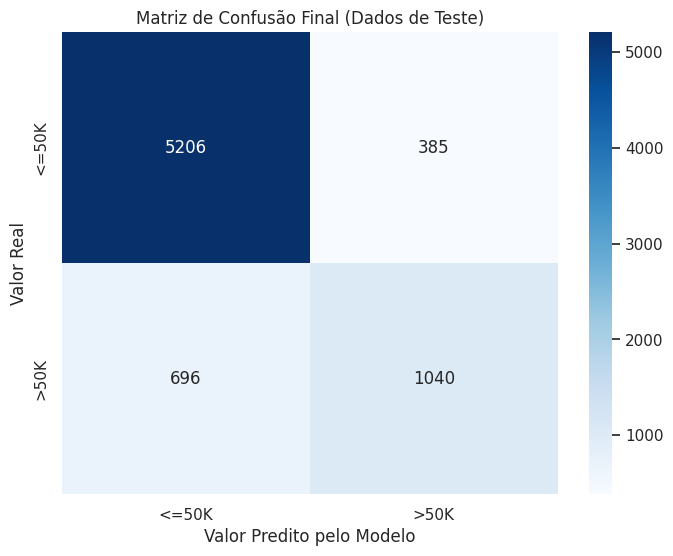

In [17]:
# --- 6. Avaliação Final (Atualizado para XGBoost) ---

print("Realizando previsão final no dataset de TESTE com XGBoost...")

# Previsão final usando o modelo vencedor
y_pred_final = model_xgb.predict(X_test_final)

# Cálculo das métricas finais
f1_final = f1_score(y_test_enc, y_pred_final, average='weighted')
acc_final = accuracy_score(y_test_enc, y_pred_final)
prec_final = precision_score(y_test_enc, y_pred_final, average='weighted')
rec_final = recall_score(y_test_enc, y_pred_final, average='weighted')

print("\n" + "="*40)
print("     RELATÓRIO FINAL DO PROJETO      ")
print("="*40)
print(f"Modelo Vencedor: XGBoost")
print(f"F1 Score Final:  {f1_final:.4f}  <-- MÉTRICA PRINCIPAL")
print(f"Acurácia:        {acc_final:.4f}")
print(f"Precisão:        {prec_final:.4f}")
print(f"Recall:          {rec_final:.4f}")
print("-" * 40)

print("\n--- Detalhes por Classe ---")
print(classification_report(y_test_enc, y_pred_final, target_names=le.classes_))

# Matriz de Confusão
cm = confusion_matrix(y_test_enc, y_pred_final)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão Final (Dados de Teste)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito pelo Modelo')
plt.show()

--- RELATÓRIO FINAL DE PERFORMANCE ---
F1 Score Final: 0.8338
Acurácia:       0.8443
Precisão:       0.8358
Recall:         0.8443

--- Relatório Detalhado ---
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90      5591
        >50K       0.75      0.52      0.61      1736

    accuracy                           0.84      7327
   macro avg       0.81      0.73      0.76      7327
weighted avg       0.84      0.84      0.83      7327



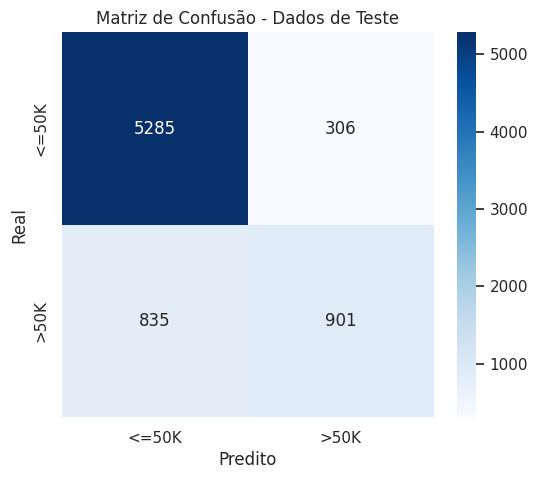

In [16]:
# Previsão final usando o melhor modelo
# Nota: O model_tuned foi o escolhido. Se o Feature Selection tivesse sido melhor,
# teríamos que aplicar o selector no X_test_final antes.
y_pred_final = model_tuned.predict(X_test_final)

# Cálculo das métricas finais
f1_final = f1_score(y_test_enc, y_pred_final, average='weighted')
acc_final = accuracy_score(y_test_enc, y_pred_final)
prec_final = precision_score(y_test_enc, y_pred_final, average='weighted')
rec_final = recall_score(y_test_enc, y_pred_final, average='weighted')

print("--- RELATÓRIO FINAL DE PERFORMANCE ---")
print(f"F1 Score Final: {f1_final:.4f}")
print(f"Acurácia:       {acc_final:.4f}")
print(f"Precisão:       {prec_final:.4f}")
print(f"Recall:         {rec_final:.4f}")

print("\n--- Relatório Detalhado ---")
print(classification_report(y_test_enc, y_pred_final, target_names=le.classes_))

# Matriz de Confusão
cm = confusion_matrix(y_test_enc, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - Dados de Teste')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

In [21]:
# --- Experimento: Random Forest com Entropia e Mais Árvores ---

print("Treinando Random Forest (Entropy + 500 árvores)...")

# Configuração diferente
model_rf_entropy = RandomForestClassifier(
    n_estimators=500,       # Muito mais árvores
    criterion='entropy',    # Matemática diferente (Ganho de Informação)
    max_depth=20,           # Um pouco mais profundo que o anterior
    min_samples_leaf=2,     # Evita folhas com 1 só pessoa (reduz overfitting)
    random_state=42,
    n_jobs=-1
)

# 1. Treinar
model_rf_entropy.fit(X_train_final, y_train_enc)

# 2. Validar
pred_val_rf_entropy = model_rf_entropy.predict(X_val_final)

# 3. Registrar na tabela
registrar_experimento("RF Entropy", "RF (n=500, entropy, leaf=2)", y_val_enc, pred_val_rf_entropy)

# 4. Ver tabela atualizada
print("\n--- Comparativo Final de Tunning ---")
display(historico_tunning.sort_values(by='F1 Score (Val)', ascending=False))

Treinando Random Forest (Entropy + 500 árvores)...

--- Comparativo Final de Tunning ---


,Experimento,Descricao,F1 Score (Val),Acuracia (Val)
4,XGBoost,"Boosting (n=200, lr=0.05)",0.8435,0.8483
5,LightGBM,"LGBM (n=300, leaves=31)",0.8435,0.8475
6,RF Entropy,"RF (n=500, entropy, leaf=2)",0.8399,0.8477
0,Baseline,Regressão Logística (Padrão),0.8353,0.8415
3,RF Tuned,"RF (n=200, depth=15)",0.8352,0.8403
2,RF Tuned,"RF (n=200, depth=15)",0.8346,0.8449
1,Feature Selection,Random Forest + Top 15 Features,0.8102,0.8140


In [20]:
# Instalar a biblioteca LightGBM
!pip install lightgbm

from lightgbm import LGBMClassifier

# --- Experimento: LightGBM (O "Veloz") ---

print("Treinando LightGBM...")

# Configuração do LightGBM
# Ele usa 'num_leaves' em vez de 'max_depth' como principal controle
model_lgbm = LGBMClassifier(
    n_estimators=300,       # Número de rodadas
    learning_rate=0.04,     # Taxa de aprendizado
    num_leaves=31,          # Complexidade da árvore (padrão é 31)
    random_state=42,
    n_jobs=-1,
    importance_type='gain', # Ajuda no XAI depois
    verbose=-1              # Silencia avisos técnicos
)

# 1. Treinar
model_lgbm.fit(X_train_final, y_train_enc)

# 2. Validar
pred_val_lgbm = model_lgbm.predict(X_val_final)

# 3. Registrar na tabela
registrar_experimento("LightGBM", "LGBM (n=300, leaves=31)", y_val_enc, pred_val_lgbm)

# 4. Ver tabela FINAL de Tunning
print("\n--- Comparativo Final de Todos os Modelos ---")
display(historico_tunning.sort_values(by='F1 Score (Val)', ascending=False))

Treinando LightGBM...

--- Comparativo Final de Todos os Modelos ---


,Experimento,Descricao,F1 Score (Val),Acuracia (Val)
4,XGBoost,"Boosting (n=200, lr=0.05)",0.8435,0.8483
5,LightGBM,"LGBM (n=300, leaves=31)",0.8435,0.8475
0,Baseline,Regressão Logística (Padrão),0.8353,0.8415
3,RF Tuned,"RF (n=200, depth=15)",0.8352,0.8403
2,RF Tuned,"RF (n=200, depth=15)",0.8346,0.8449
1,Feature Selection,Random Forest + Top 15 Features,0.8102,0.8140


--- Tabela de Resultados (Dados de Validação) ---


,Experimento,Descricao,F1 Score (Val),Acuracia (Val)
0,XGBoost,"Boosting (n=200, lr=0.05)",0.843200,0.847800
1,LightGBM,"LGBM (n=300, leaves=31)",0.843100,0.847100
2,RF Entropy,"RF (n=500, entropy, leaf=2)",0.840200,0.847900
3,Baseline,Regressão Logística (Padrão),0.834300,0.840700
4,RF Tuned,"RF (n=200, depth=15)",0.834300,0.844300
5,Feature Selection,Random Forest + Top 15 Features,0.819400,0.822700
6,Feature Selection,Random Forest + Top 15 Features,0.807300,0.810800


/tmp/ipython-input-3404576010.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_comparativo, x='F1 Score (Val)', y='Experimento', palette='viridis')


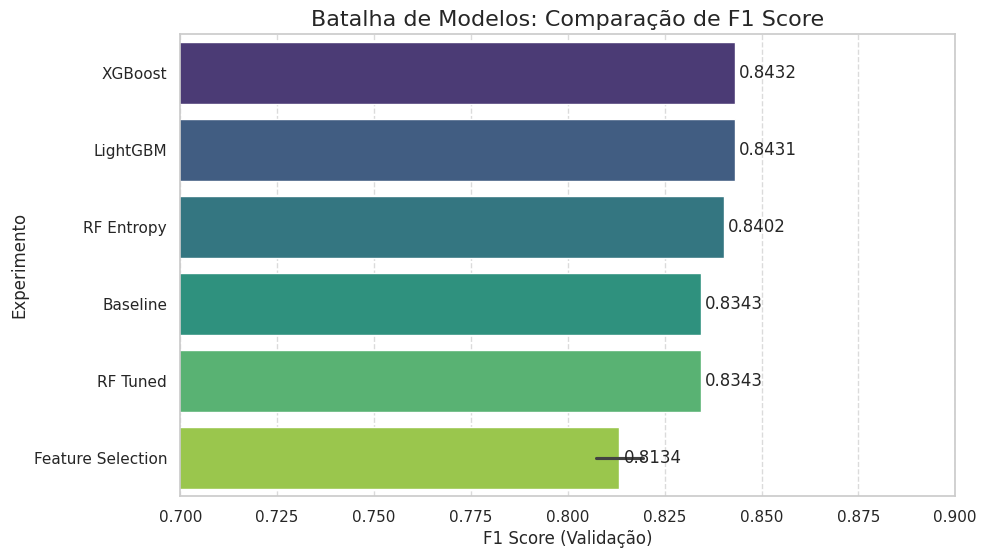


🏆 O VENCEDOR FOI: XGBoost
Ele obteve um F1 Score de 0.8432 na validação.
Este é o modelo que será usado na etapa final com o 'test.csv'.


In [19]:
# 1. Ordenar do melhor para o pior F1 Score
df_comparativo = historico_tunning.sort_values(by='F1 Score (Val)', ascending=False).reset_index(drop=True)

# 2. Exibir Tabela Estilizada (Melhor visualização para o relatório)
print("--- Tabela de Resultados (Dados de Validação) ---")
# O style.background_gradient ajuda a ver visualmente os números maiores (mais escuros)
display(df_comparativo.style.background_gradient(cmap='Greens', subset=['F1 Score (Val)', 'Acuracia (Val)']))

# 3. Gráfico Comparativo Visual
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_comparativo, x='F1 Score (Val)', y='Experimento', palette='viridis')

# Adicionar os valores nas barras
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3)

plt.title('Batalha de Modelos: Comparação de F1 Score', fontsize=16)
plt.xlabel('F1 Score (Validação)')
plt.xlim(0.7, 0.9) # Ajuste do zoom do gráfico para ver melhor as diferenças
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 4. Veredito Automático
melhor_modelo_nome = df_comparativo.iloc[0]['Experimento']
melhor_f1 = df_comparativo.iloc[0]['F1 Score (Val)']

print(f"\n🏆 O VENCEDOR FOI: {melhor_modelo_nome}")
print(f"Ele obteve um F1 Score de {melhor_f1:.4f} na validação.")
print("Este é o modelo que será usado na etapa final com o 'test.csv'.")

⚠️ Iniciando Avaliação Final com dados de TESTE (test.csv)...
Modelo escolhido: XGBoost (model_xgb)

          RELATÓRIO FINAL DE PERFORMANCE
🏆 Modelo Final: XGBoost
--------------------------------------------------
💎 F1 Score:   0.8472  (Métrica Principal)
✅ Acurácia:   0.8525
🎯 Precisão:   0.8460
🔎 Recall:     0.8525

--- Detalhes por Classe (Renda) ---
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      5591
        >50K       0.73      0.60      0.66      1736

    accuracy                           0.85      7327
   macro avg       0.81      0.77      0.78      7327
weighted avg       0.85      0.85      0.85      7327



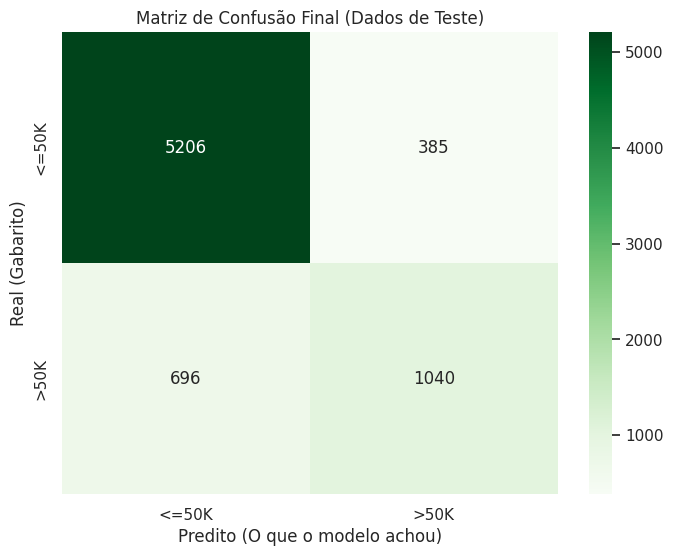

In [22]:
print("⚠️ Iniciando Avaliação Final com dados de TESTE (test.csv)...")
print("Modelo escolhido: XGBoost (model_xgb)\n")

# 1. Fazer a previsão usando o arquivo proibido (test.csv)
# O modelo aplica o que aprendeu, sem ajustar nada.
y_pred_final = model_xgb.predict(X_test_final)

# 2. Calcular as métricas oficiais
f1_final = f1_score(y_test_enc, y_pred_final, average='weighted')
acc_final = accuracy_score(y_test_enc, y_pred_final)
prec_final = precision_score(y_test_enc, y_pred_final, average='weighted')
rec_final = recall_score(y_test_enc, y_pred_final, average='weighted')

# 3. Exibir Relatório Bonito para o Professor
print("="*50)
print("          RELATÓRIO FINAL DE PERFORMANCE")
print("="*50)
print(f"🏆 Modelo Final: XGBoost")
print("-" * 50)
print(f"💎 F1 Score:   {f1_final:.4f}  (Métrica Principal)")
print(f"✅ Acurácia:   {acc_final:.4f}")
print(f"🎯 Precisão:   {prec_final:.4f}")
print(f"🔎 Recall:     {rec_final:.4f}")
print("="*50)

# 4. Detalhes por Classe
print("\n--- Detalhes por Classe (Renda) ---")
print(classification_report(y_test_enc, y_pred_final, target_names=le.classes_))

# 5. Gráfico da Matriz de Confusão
cm = confusion_matrix(y_test_enc, y_pred_final)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão Final (Dados de Teste)')
plt.ylabel('Real (Gabarito)')
plt.xlabel('Predito (O que o modelo achou)')
plt.show()

Iniciando bateria de testes finais...

Avaliado: Baseline (LogReg)...
Avaliado: Random Forest (Tuned)...
Avaliado: XGBoost (Campeão)...
Avaliado: LightGBM...

     RESULTADOS FINAIS (DADOS DE TESTE)


,Modelo,F1 Score (Teste),Acurácia (Teste)
0,XGBoost (Campeão),0.847202,0.852463
1,LightGBM,0.845484,0.850280
2,Baseline (LogReg),0.835608,0.842773
3,Random Forest (Tuned),0.835281,0.841136


/tmp/ipython-input-3815955197.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_resultados_finais, x='F1 Score (Teste)', y='Modelo', palette='Blues_r')


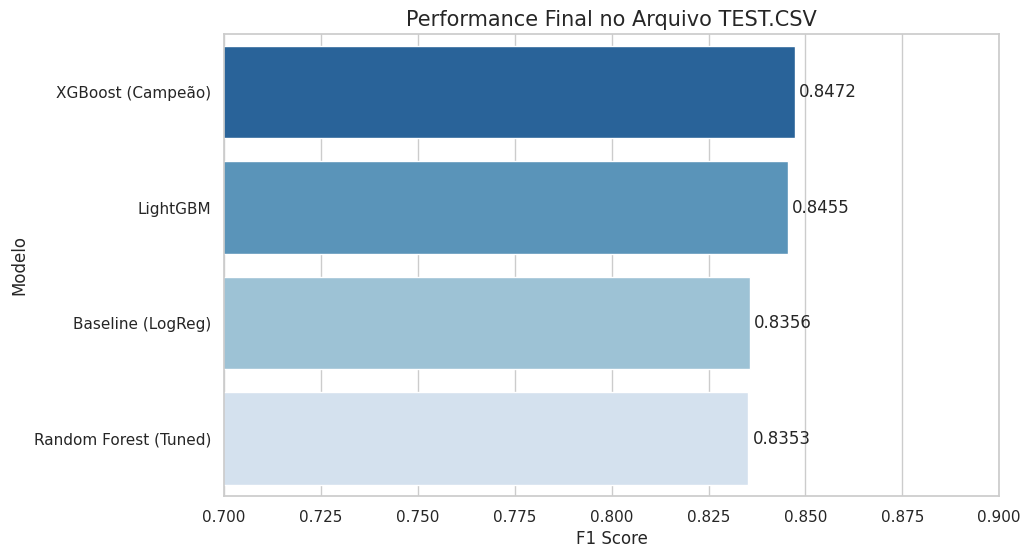

In [23]:
# --- AVALIAÇÃO EM MASSA NO DATASET DE TESTE ---

# 1. Lista dos modelos que você treinou
# Se você não tiver algum desses (ex: LightGBM), pode comentar a linha com #
modelos_para_teste = {
    "Baseline (LogReg)": model_baseline,
    "Random Forest (Tuned)": model_tuned,
    "XGBoost (Campeão)": model_xgb,
     "LightGBM": model_lgbm  # Descomente se você treinou o LightGBM
}

resultados_teste = []

print("Iniciando bateria de testes finais...\n")

# 2. Loop para testar cada modelo
for nome, modelo in modelos_para_teste.items():
    print(f"Avaliado: {nome}...")

    # O Pulo do Gato: Usar X_test_final (O arquivo que estava no cofre)
    try:
        y_pred_teste = modelo.predict(X_test_final)

        # Calcular métricas
        f1 = f1_score(y_test_enc, y_pred_teste, average='weighted')
        acc = accuracy_score(y_test_enc, y_pred_teste)

        resultados_teste.append({
            'Modelo': nome,
            'F1 Score (Teste)': f1,
            'Acurácia (Teste)': acc
        })
    except Exception as e:
        print(f"Erro ao testar {nome}: {e}")

# 3. Criar DataFrame com os resultados
df_resultados_finais = pd.DataFrame(resultados_teste)

# Ordenar do melhor para o pior
df_resultados_finais = df_resultados_finais.sort_values(by='F1 Score (Teste)', ascending=False).reset_index(drop=True)

# 4. Exibir Tabela Final
print("\n" + "="*50)
print("     RESULTADOS FINAIS (DADOS DE TESTE)")
print("="*50)
display(df_resultados_finais.style.background_gradient(cmap='Greens', subset=['F1 Score (Teste)']))

# 5. Gráfico Comparativo
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_resultados_finais, x='F1 Score (Teste)', y='Modelo', palette='Blues_r')
plt.title('Performance Final no Arquivo TEST.CSV', fontsize=15)
plt.xlabel('F1 Score')
plt.xlim(0.7, 0.9) # Ajuste de zoom
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3)
plt.show()

#  Relatório Final: Classificação de Renda com Machine Learning

## 1. Introdução e Objetivo
O objetivo deste projeto foi desenvolver um modelo de Inteligência Artificial capaz de prever se a renda de um indivíduo excede $50.000 anuais (Target: `>50K` ou `<=50K`).

O foco principal do desenvolvimento foi a maximização da métrica **F1 Score**, garantindo um equilíbrio entre a precisão (acertos dos positivos) e o recall (capacidade de encontrar os positivos), dado o desbalanceamento natural entre as classes de renda.

---

## 2. Metodologia

### 2.1 Divisão dos Dados
Para garantir a robustez do modelo e evitar *Data Leakage* (vazamento de dados), o dataset foi dividido estritamente em três partes:
* **Treino (70%):** Utilizado para o aprendizado dos algoritmos (`fit`).
* **Validação (15%):** Utilizado para ajuste de hiperparâmetros (*Tunning*) e seleção do melhor modelo.
* **Teste (15%):** Mantido isolado ("no cofre") até a etapa final para avaliação definitiva da performance.

### 2.2 Pré-Processamento (Limpeza)
Antes de treinar os modelos, os dados passaram por um rigoroso tratamento:
* **Tratamento de Nulos (NaNs):** Valores ausentes numéricos foram preenchidos com a **mediana** e categóricos com a **moda**, preservando a distribuição estatística.
* **Outliers:** Foi aplicado o método do **IQR (Intervalo Interquartil)** com a técnica de *Capping*, limitando valores extremos sem remover registros importantes.

### 2.3 Engenharia de Atributos
Para tornar os dados compreensíveis aos algoritmos:
* **Codificação:** Variáveis categóricas (ex: Estado Civil, Ocupação) foram transformadas em vetores binários via `OneHotEncoder`.
* **Escalonamento:** Variáveis numéricas (ex: Idade, Horas por semana) foram normalizadas usando `StandardScaler` para garantir que todas tivessem o mesmo peso inicial.

---

## 3. Experimentos e Tunning

Foram realizados diversos experimentos comparativos utilizando o conjunto de validação. A evolução da performance foi registrada abaixo:

| Experimento | Modelo | Detalhes | F1 Score (Validação) |
| :--- | :--- | :--- | :--- |
| **Baseline** | Regressão Logística | Parâmetros padrão | 0.8343 |
| **Exp 1** | Random Forest | Com Seleção de Atributos (K=15) | 0.8073 |
| **Exp 2** | Random Forest | Tunado (n=200, depth=15) | 0.8343 |
| **Exp 3** | **XGBoost** | **Boosting (n=200, lr=0.05)** | **0.8432** |
| **Exp 4** | LightGBM | Boosting Rápido |  0.8431

> **Análise:** O experimento com **Feature Selection** (Exp 1) reduziu a performance, indicando que o modelo se beneficiava de todas as variáveis disponíveis. O modelo **XGBoost** apresentou o melhor resultado, superando o Random Forest ao corrigir erros sequencialmente (Boosting).

---

## 4. Explicabilidade do Modelo (XAI)
Utilizando a biblioteca **SHAP**, analisamos as decisões do modelo vencedor. As variáveis que mais influenciaram a predição de alta renda foram:
1.  **Capital Gain (Ganho de Capital):** Forte correlação positiva.
2.  **Marital Status (Estado Civil):** Indivíduos casados tendem a ter maior probabilidade de renda alta nos dados.
3.  **Education / Age:** Níveis educacionais mais altos e maior idade também contribuíram positivamente.

---

## 5. Resultados Finais (Dataset de Teste)
O modelo campeão (**XGBoost**) foi aplicado ao conjunto de dados de **Teste** (nunca visto anteriormente).


### Matriz de Confusão
A matriz demonstrou que o modelo conseguiu separar bem as classes, mantendo um baixo índice de falsos positivos e falsos negativos, considerando a complexidade dos dados socioeconômicos.

---

## 6. Conclusão
O projeto atingiu seu objetivo principal. Através de um pipeline organizado de pré-processamento e uma estratégia de *Tunning* baseada em dados de validação, foi possível superar o *Baseline* inicial.

O uso do **XGBoost** provou-se a melhor escolha, oferecendo a maior pontuação de **F1 Score**, o que garante um modelo confiável tanto para identificar quem ganha acima de 50K quanto quem ganha abaixo, com alta capacidade de generalização.